# ADTA 5900: CNN on CIFAR-10: Final Project

## Set Path for Data Folder

In [1]:
 # Put file path as a string here

CIFAR_DIR = 'CIFAR_10_DATA/'

## Load Data

In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        cifar_dict = pickle.load(fo, encoding='bytes')
    return cifar_dict

In [3]:
dirs = ['batches.meta','data_batch_1','data_batch_2','data_batch_3','data_batch_4','data_batch_5','test_batch']

all_data = [0,1,2,3,4,5,6]

for i,direc in zip(all_data,dirs):
    all_data[i] = unpickle(CIFAR_DIR+direc)

In [4]:
batch_meta = all_data[0]
data_batch1 = all_data[1]
data_batch2 = all_data[2]
data_batch3 = all_data[3]
data_batch4 = all_data[4]
data_batch5 = all_data[5]
test_batch = all_data[6]

In [5]:
batch_meta

{b'num_cases_per_batch': 10000,
 b'label_names': [b'airplane',
  b'automobile',
  b'bird',
  b'cat',
  b'deer',
  b'dog',
  b'frog',
  b'horse',
  b'ship',
  b'truck'],
 b'num_vis': 3072}

In [6]:
data_batch1.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

## Display several examples of single images using matplotlib 

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

In [8]:
X = data_batch1[b"data"] 

In [9]:
X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")

In [10]:
X[0].max()

255

In [11]:
(X[0]/255).max()

1.0

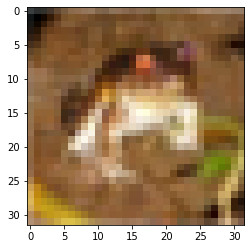

In [12]:
plt.imshow(X[0])

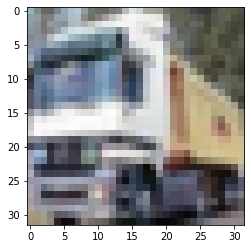

In [13]:
plt.imshow(X[1])

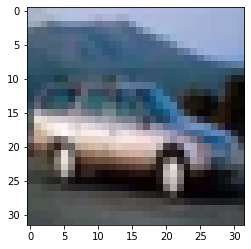

In [14]:
plt.imshow(X[4])

## Supporting Functions to Rearrange Data

### Encode Labels into One-Hot Format

In [15]:
def one_hot_encode(vec, vals=10):
    '''
    For use to one-hot encode the 10- possible labels
    '''
    n = len(vec)
    out = np.zeros((n, vals))
    out[range(n), vec] = 1
    return out

## Set Up Image Data: Make it Ready to be Fed into 1st Conv Layer

In [16]:
class CifarHelper():
    
    def __init__(self):
        self.i = 0
        
        self.all_train_batches = [data_batch1,data_batch2,data_batch3,data_batch4,data_batch5]
        self.test_batch = [test_batch]
        
        self.training_images = None
        self.training_labels = None
        
        self.test_images = None
        self.test_labels = None
    
    def set_up_images(self):
        
        print("Setting Up Training Images and Labels")
        
        self.training_images = np.vstack([d[b"data"] for d in self.all_train_batches])
        train_len = len(self.training_images)
        
        self.training_images = self.training_images.reshape(train_len,3,32,32).transpose(0,2,3,1)/255
        self.training_labels = one_hot_encode(np.hstack([d[b"labels"] for d in self.all_train_batches]), 10)
        
        print("Setting Up Test Images and Labels")
        
        self.test_images = np.vstack([d[b"data"] for d in self.test_batch])
        test_len = len(self.test_images)
        
        self.test_images = self.test_images.reshape(test_len,3,32,32).transpose(0,2,3,1)/255
        self.test_labels = one_hot_encode(np.hstack([d[b"labels"] for d in self.test_batch]), 10)

        
    def next_batch(self, batch_size):
        x = self.training_images[self.i:self.i+batch_size].reshape(100,32,32,3)
        y = self.training_labels[self.i:self.i+batch_size]
        self.i = (self.i + batch_size) % len(self.training_images)
        return x, y

## Set up image data: Calling CifarHelper.set_up_images()

In [17]:
# Before Your tf.Session run these two lines
ch = CifarHelper()
ch.set_up_images()

# During your session to grab the next batch use this line
# (Just like we did for mnist.train.next_batch)
# batch = ch.next_batch(100)

Setting Up Training Images and Labels
Setting Up Test Images and Labels


## Define Supporting Functions to Build, Train, and Test CNN Model

#### Initialize weights in filter

In [18]:
#This function returns a tf.variable used to store weights in a filter
#This variable is initialised with values that can be used to initialize the weights
#The values are random numbers
    
def initialize_weights (filter_shape):
    init_random_dist = tf.truncated_normal(filter_shape, stddev=0.1)
    return(tf.Variable(init_random_dist))

#### Initialize bias

In [19]:
#This function returns a tf.variable used to store bias
#This variable is initialised with values that can be used to initialize bias
#The value is initialised to 0.1
    
def initialize_bias (bias_shape):
    initial_bias_vals = tf.constant(0.1,shape=bias_shape)
    return(tf.Variable(initial_bias_vals))

#### Setup convolution layer and perform convolution computation: Dot Product(x*W)

In [20]:
#define a function to setup a convolution layer (conv2d)
#parameters:
    #inputs: [batch,H,W,Channels]
    #filter_shape: [filter H, filter W, in_channels(in_depth=in_num_filters), out_channels(out_depth=out_num_filters)]
        #example: [3,3,3,64]
#return: Outputs of the layer: The dot product: inputs*weights: x*w
        
def create_convolution_layer_and_compute_dot_product(inputs, filter_shape):
    #initialize the wieghts in the filter
    filter_initialized_with_weights=initialize_weights(filter_shape)
    
    #create a colvolution layer
    conv_layer_outputs=tf.nn.conv2d(inputs, filter_initialized_with_weights, strides=[1,1,1,1], padding=('SAME'))
    
    #return the convolution layer outputs
    return(conv_layer_outputs)

#### Setup a ReLU layer and perform computation: Dot Product + Bias (x.W + b)

In [21]:
#Function is defined
    #First, to setup a ReLU layer (an activation function layer)
    #then, to prrform the computation: dot product+bias: (x+W)+b
    
#ReLU: is a rectifiled linear unit, a popular activation function used in CNN
#in this layer, the bias has been initialised
#parameters:
    #inputs: Outputs from the preceeding convolution layer: Dot product inputs * weights
    #filter_shape: [filter H, filter W, in_channels(in_depth=in_num_filters), out_channels(out_depth=out_num_filters)]
        #example: [3,3,3,64]
#return: Outputs of the layer: The dot product + b: (x*W)+b

def create_relu_layer_and_compute_dotproduct_plus_b(inputs, filter_shape):
    #initialize bias for each input channel
    b=initialize_bias([filter_shape[3]])
    
    #perform the computation first by adding: inputs (x*W) + b
    #create a ReLU layer associated with the preceeding convolution layer
    relu_layer_outputs=tf.nn.relu(inputs+b)
    
    #return the outputs of the relu layer
    return (relu_layer_outputs)

#### Setup a pooling layer and reduce the spacial size

In [22]:
#Function is defined
    #First, to create a pooling layer
    #then, to reduce the spatial size of the inputs data
    
#pooling method: max pooling
#kernel size: 2*2
#stride:2

#parameters: 
    #inputs: Outputs of the preceeding layer
    #return: Outputs of the layer
    
def create_maxpool2by2_and_reduce_spacial_size(inputs):
    #create a pooling layer
    pooling_layer_outputs=tf.nn.max_pool(inputs,ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    
    #return the pooling layer
    return (pooling_layer_outputs)

#### Setup fully connected layer and perform computation: (inputs*weights)+Bias

In [23]:
#define a function to setup a fully connected layer
#Also perform computation: (Dot Product (inputs*weights))+bias
#return the results
#parameters: 
    #inputs: Outputs of the preceeding layer
    #size: The size of the outputs, i.e., number of out_channels
    
def create_fully_connected_layer_and_compute_dotproduct_plus_bias(inputs,output_size):
    #get the number of input channels from the inpt
    #inputs: the outputs from the preceding layer or previous operation like reshaping
    input_size=int(inputs.get_shape()[1])
    
    #Initialise the weights of the filter of the FC layer
    #Filter shape [in_channels, out_channels]
    #each weight for one filter cell
    W=initialize_weights([input_size, output_size])
    
    #initialize the bias: each bias one output channel
    b=initialize_bias([output_size])
    
    #First: Perform the computation for the FC layer: Dot product inputs*W
    #Then: Add bias to get the results: Outputs of the FC layer
    fc_xW_plus_bias_outputs=tf.matmul(inputs,W)+b
    
    #return the results: outputs
    return(fc_xW_plus_bias_outputs)

# PHASE I: Build Convolutional Neural Network

In [24]:
import tensorflow as tf

## Create Placeholders for Inputs and Labels: x and y_true

In [25]:
# PLACEHOLDER

# Create a placeholder for the inputs data: x
# x: a 2D array
# x: a placeholder that can hold any number of rows/record

x = tf.placeholder(tf.float32, shape=[None, 32, 32, 3])

## Reshape the Input Placeholder x: NOT NEED TO RESHAPE DATA HERE

In [26]:
# PLACEHOLDER

# Create a placeholder for the labels of the inputs data: y_true
# y_true: a 2D array
# y_true: Can hold any number of rows/records

y_true = tf.placeholder(tf.float32, [None, 10])

### Create 1st Convolution Layer and ReLU Layer and Perform Computation: x*W+b

In [27]:
#create 1st convolutional layer
#inputs: x
#filter shape: [3,3,3,64]
    #filter: 3*3
    #Input Channels: 3
    #Output Channels: 64
    
#create the 1st convolution layer
#Then learn/extract the features, get the results(output): Dot product of inputs*weights
#Return the output of the layer

conv_layer_1_outputs=create_convolution_layer_and_compute_dot_product(x, filter_shape=[3,3,3,64])

#create the relu layer for the 1st convolutional layer
#accept the outputs from the first conv layer as inputs
#perform the computation at the layer: add inputs + bias
#return the outputs of the layer

conv_relu_layer_1_outputs=create_relu_layer_and_compute_dotproduct_plus_b(conv_layer_1_outputs, filter_shape=[3,3,3,64])

### Create 1st Pooling Layer and Reduce Spatial Size

In [28]:
#create the 1st pooling layer
#Then reduce the spatial size of the input data
#Return: Outputs of the layer

pooling_layer_1_outputs=create_maxpool2by2_and_reduce_spacial_size(conv_relu_layer_1_outputs)

### Create 2nd Convolution Layer and ReLU Layer and Perform Computation: x*W+b

In [29]:
#create 2nd convolutional layer
#inputs: x
#filter shape: [3,3,64,128]
    #filter: 3*3
    #Input Channels: 64
    #Output Channels: 128
    
#create the 2nd convolution layer
#Then learn/extract the features, get the results(output): Dot product of inputs*weights
#Return the output of the layer

conv_layer_2_outputs=create_convolution_layer_and_compute_dot_product(pooling_layer_1_outputs, filter_shape=[3,3,64,128])

#create the relu layer for the 1st convolutional layer
#accept the outputs from the first conv layer as inputs
#perform the computation at the layer: add inputs + bias
#return the outputs of the layer

conv_relu_layer_2_outputs=create_relu_layer_and_compute_dotproduct_plus_b(conv_layer_2_outputs, filter_shape=[3,3,64,128])

### Create 2nd Pooling Layer and Reduce Spatial Size

In [30]:
#create the 2nd pooling layer
#Then reduce the spatial size of the input data
#Return: Outputs of the layer

pooling_layer_2_outputs=create_maxpool2by2_and_reduce_spacial_size(conv_relu_layer_2_outputs)

### Create 3rd Convolution Layer and ReLU Layer and Perform Computation: x*W+b

In [31]:
#create 3rd convolutional layer
#inputs: x
#filter shape: [3,3,64,128]
    #filter: 3*3
    #Input Channels: 64
    #Output Channels: 128
    
#create the 2nd convolution layer
#Then learn/extract the features, get the results(output): Dot product of inputs*weights
#Return the output of the layer

conv_layer_3_outputs=create_convolution_layer_and_compute_dot_product(pooling_layer_2_outputs, filter_shape=[3,3,128,256])

#create the relu layer for the 1st convolutional layer
#accept the outputs from the first conv layer as inputs
#perform the computation at the layer: add inputs + bias
#return the outputs of the layer

conv_relu_layer_3_outputs=create_relu_layer_and_compute_dotproduct_plus_b(conv_layer_3_outputs, filter_shape=[3,3,128,256])

### Create 3rd Pooling Layer and Reduce Spatial Size

In [32]:
#create the 2nd pooling layer
#Then reduce the spatial size of the input data
#Return: Outputs of the layer

pooling_layer_3_outputs=create_maxpool2by2_and_reduce_spacial_size(conv_relu_layer_3_outputs)

### Flatten data to make it ready to be fed into 1st FC layer

In [33]:
pooling_layer_3_outputs_flat=tf.contrib.layers.flatten(pooling_layer_3_outputs)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.


### Create 1st FC layer, ReLU layer, and output data to dropout layer

In [34]:
#First, create the FC layer
#Feed the output(already flattened) of the 2nd pooling layer as the inputs to this layer
#then perform the computation: dot product+bias(x*W)+b

#parameters:
    #pooling_layer_2_outputs_flat
    #output_size:1024 out channels
    
#return: outputs of the computation: (x * W) + b

fc_layer_1_outputs=create_fully_connected_layer_and_compute_dotproduct_plus_bias(pooling_layer_3_outputs_flat, output_size=1024)

#create the activation (ReLU) layer of the 1st FC layer
#return: outputs of the layer

fc_relu_layer_1_outputs=tf.nn.relu(fc_layer_1_outputs)

### Create dropout layer and dropout a fraction of outputs randomly

In [35]:
#declare a placeholder to hold the value of probability (percentage %) to keep
#i.e., the percentage % of the total output channels that will be kept
#e.g.,: keep_prob=hold_prob=50%-->keep 50%-->dropout-->50%
#which modes/channels to keep or dropout: selected randomly

hold_prob=tf.placeholder(tf.float32)

#dropout
#set the outputs to 0 (zero) so that they will be ignored in the next layer

fc_dropout_outputs=tf.nn.dropout(fc_relu_layer_1_outputs, keep_prob=hold_prob)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


### Create a Final FC layer, Compute (x.W+b), and produce final outputs

In [36]:
#create the final FC layer
#then compute: x*W+b
#parameters:
    #fc_dropout_outputs: outputs from the dropout layer
    
#return y_pred: final predicted outputs

y_pred=create_fully_connected_layer_and_compute_dotproduct_plus_bias(fc_dropout_outputs, output_size=10)

### Define loss function and calculate softmax cross entropy loss

In [37]:
#define loss function: cross-entropy with logits, i.e., with the final outputs
#calculate the softmax cross-entropy loss
softmax_cross_entropy_loss=tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred)

#compute the mean of losses
cross_entropy_mean=tf.reduce_mean(softmax_cross_entropy_loss)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



### Create an optimizer to optimize CNN model and set learning rate

In [38]:
#get an ADAM optimizer
optimizer=tf.train.AdamOptimizer(learning_rate=0.001)

### Create a trainer to train the CNN model

In [39]:
#create a CNN model trainer that can train the model
#and optimize the model by minimizing the softmax cross-entropy loss
cnn_trainer=optimizer.minimize(cross_entropy_mean)

# PHASE II: Train and Test CNN Model on CIFAR-10 Dataset

### Create a variable initializer to initialize all variables

In [40]:
#get a variable initializer
vars_initializer=tf.global_variables_initializer()

### Set the steps and define the Batch

In [41]:
#x train has total of 50000 images
#1 step: run the whole process (each time of training)
#each step, each time of training , use one batch of inputs 
#batch size=100 images
#total no.of batches=50000/100=500

#steps=5000, i.e., finish the training after 5000 steps

steps=8000
batch = ch.next_batch(100)

### Run tf.Session() to train and test CNN model

In [42]:
meanacc=[]
with tf.Session() as sess:
    #First, run vars_initializer to initialize all variables
    sess.run(vars_initializer)
    for i in range(steps):
        #each batch: 100 images
        batch_x,batch_y = ch.next_batch(100)
        
        #train the model
        #dropout keep_prob (% to keep):0.5 --> 50% will be dropped out
        sess.run(cnn_trainer,feed_dict={x:batch_x,y_true:batch_y,hold_prob:0.5})

        
        #test the model: at each 100th step
        #run the block of code for each 100 times of training, each time run a batch
        if i % 100 == 0:
            print('ON STEP: {}'.format(i))
            
            #COMPARE TO find matches of y_pred and y_true
            matches=tf.equal(tf.argmax(y_pred,axis=1),tf.argmax(y_true,axis=1))
            
            #cost the matches from integers to tf.float32
            #calculate the accuracy using the mean of matches
            acc=tf.reduce_mean(tf.cast(matches,tf.float32))
            
            #test the model at each 100th step
            #using test dataset
            #dropout: NONE because of the test , not training
            test_accuracy=sess.run(acc,feed_dict={x:batch_x,y_true:batch_y,hold_prob:1.0})
            meanacc.append(test_accuracy)
            
            print('ACCURACY: ',test_accuracy*100)
            print('MEAN ACCURACY: ',np.mean(meanacc)*100)
            print('\n')

ON STEP: 0
ACCURACY:  15.000000596046448
MEAN ACCURACY:  15.000000596046448


ON STEP: 100
ACCURACY:  40.99999964237213
MEAN ACCURACY:  28.00000011920929


ON STEP: 200
ACCURACY:  51.99999809265137
MEAN ACCURACY:  35.999998450279236


ON STEP: 300
ACCURACY:  50.999999046325684
MEAN ACCURACY:  39.74999785423279


ON STEP: 400
ACCURACY:  54.00000214576721
MEAN ACCURACY:  42.59999692440033


ON STEP: 500
ACCURACY:  61.000001430511475
MEAN ACCURACY:  45.666661858558655


ON STEP: 600
ACCURACY:  57.999998331069946
MEAN ACCURACY:  47.428566217422485


ON STEP: 700
ACCURACY:  58.99999737739563
MEAN ACCURACY:  48.875001072883606


ON STEP: 800
ACCURACY:  62.99999952316284
MEAN ACCURACY:  50.4444420337677


ON STEP: 900
ACCURACY:  62.00000047683716
MEAN ACCURACY:  51.5999972820282


ON STEP: 1000
ACCURACY:  68.99999976158142
MEAN ACCURACY:  53.1818151473999


ON STEP: 1100
ACCURACY:  73.00000190734863
MEAN ACCURACY:  54.83333468437195


ON STEP: 1200
ACCURACY:  70.99999785423279
MEAN ACCURACY: 

In [43]:
ACC_cnn_cifar_10=meanacc
print(ACC_cnn_cifar_10)

[0.15, 0.41, 0.52, 0.51, 0.54, 0.61, 0.58, 0.59, 0.63, 0.62, 0.69, 0.73, 0.71, 0.67, 0.67, 0.79, 0.76, 0.76, 0.72, 0.8, 0.77, 0.82, 0.75, 0.75, 0.8, 0.83, 0.83, 0.83, 0.76, 0.81, 0.91, 0.89, 0.87, 0.81, 0.86, 0.9, 0.89, 0.92, 0.84, 0.86, 0.93, 0.94, 0.93, 0.9, 0.95, 0.96, 0.96, 0.93, 0.9, 0.96, 0.94, 0.95, 0.91, 0.92, 0.94, 0.96, 0.96, 0.96, 0.95, 0.97, 0.97, 1.0, 0.98, 0.96, 0.97, 0.99, 0.99, 0.96, 0.98, 0.99, 1.0, 1.0, 0.97, 0.98, 0.98, 1.0, 1.0, 1.0, 1.0, 0.99]


In [44]:
np.mean(ACC_cnn_cifar_10)*100

84.61250066757202